
# Alpha Factor Evaluation

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import os, sys
from time import time

from pathlib import Path
import numpy as np
import pandas as pd
import pandas_datareader.data as web

import statsmodels.api as sm
from linearmodels.asset_pricing import LinearFactorModel
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import scale
import lightgbm as lgb
from scipy.stats import spearmanr
import shap

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV

In [4]:
sns.set_style('whitegrid')
idx = pd.IndexSlice
deciles = np.arange(.1, 1, .1).round(1)

## Load Data

In [6]:
factors = (pd.concat([pd.read_hdf('data.h5', 'factors/common'),
                      pd.read_hdf('data.h5', 'factors/formulaic')
                      .rename(columns=lambda x: f'alpha_{int(x):03}')],
                     axis=1)
           .dropna(axis=1, thresh=100000)
           .sort_index())

In [7]:
factors.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1255093 entries, ('A', Timestamp('2007-01-04 00:00:00')) to ('ZION', Timestamp('2016-12-29 00:00:00'))
Columns: 135 entries, sector to alpha_101
dtypes: float64(124), int64(11)
memory usage: 1.3+ GB


In [14]:
fwd_returns = factors.filter(like='fwd').columns
features = factors.columns.difference(fwd_returns).tolist()
alphas = pd.Index([f for f in features if f.startswith('alpha')])

In [15]:
features

['AARONOSC',
 'AD',
 'ADOSC',
 'ADX',
 'ADXR',
 'ALPHA_21',
 'ALPHA_252',
 'ALPHA_63',
 'ATR',
 'BB_LOW',
 'BB_SQUEEZE',
 'BB_UP',
 'BOP',
 'CCI',
 'CMA_21',
 'CMA_252',
 'CMA_63',
 'HML_21',
 'HML_252',
 'HML_63',
 'HT',
 'MACD',
 'MACD_HIST',
 'MACD_SIGNAL',
 'MARKET_21',
 'MARKET_252',
 'MARKET_63',
 'MFI',
 'OBV',
 'PPO',
 'RMW_21',
 'RMW_252',
 'RMW_63',
 'RSI',
 'SAR',
 'SMB_21',
 'SMB_252',
 'SMB_63',
 'STOCH',
 'STOCHRSI',
 'ULTOSC',
 'WILLR',
 'alpha_001',
 'alpha_002',
 'alpha_003',
 'alpha_004',
 'alpha_005',
 'alpha_006',
 'alpha_007',
 'alpha_008',
 'alpha_009',
 'alpha_010',
 'alpha_011',
 'alpha_012',
 'alpha_013',
 'alpha_014',
 'alpha_015',
 'alpha_016',
 'alpha_017',
 'alpha_018',
 'alpha_019',
 'alpha_020',
 'alpha_021',
 'alpha_022',
 'alpha_023',
 'alpha_024',
 'alpha_025',
 'alpha_026',
 'alpha_027',
 'alpha_028',
 'alpha_029',
 'alpha_030',
 'alpha_031',
 'alpha_032',
 'alpha_033',
 'alpha_034',
 'alpha_035',
 'alpha_036',
 'alpha_037',
 'alpha_038',
 'alpha_039',
 'alpha_040',
 'alpha_041',
 'alpha_042',
 'alpha_043',
 'alpha_044',
 'alpha_045',
 'alpha_046',
 'alpha_047',
 'alpha_049',
 'alpha_050',
 'alpha_051',
 'alpha_052',
 'alpha_053',
 'alpha_054',
 'alpha_055',
 'alpha_057',
 'alpha_060',
 'alpha_061',
 'alpha_062',
 'alpha_064',
 'alpha_065',
 'alpha_066',
 'alpha_068',
 'alpha_071',
 'alpha_073',
 'alpha_074',
 'alpha_075',
 'alpha_077',
 'alpha_078',
 'alpha_083',
 'alpha_084',
 'alpha_085',
 'alpha_086',
 'alpha_092',
 'alpha_094',
 'alpha_095',
 'alpha_098',
 'alpha_099',
 'alpha_101',
 'ret_01',
 'ret_02',
 'ret_03',
 'ret_04',
 'ret_05',
 'ret_10',
 'ret_126',
 'ret_21',
 'ret_252',
 'ret_42',
 'ret_63',
 'sector',
 'size_factor',
 'size_proxy']

In [16]:
len(alphas)

78

## Factor Correlation

### 'Classic' Factors

In [19]:
corr_common = factors.drop(fwd_returns.union(alphas), axis=1).corr(method='spearman')

In [ ]:
corr_common.to_hdf('data.h5', 'correlation/common')

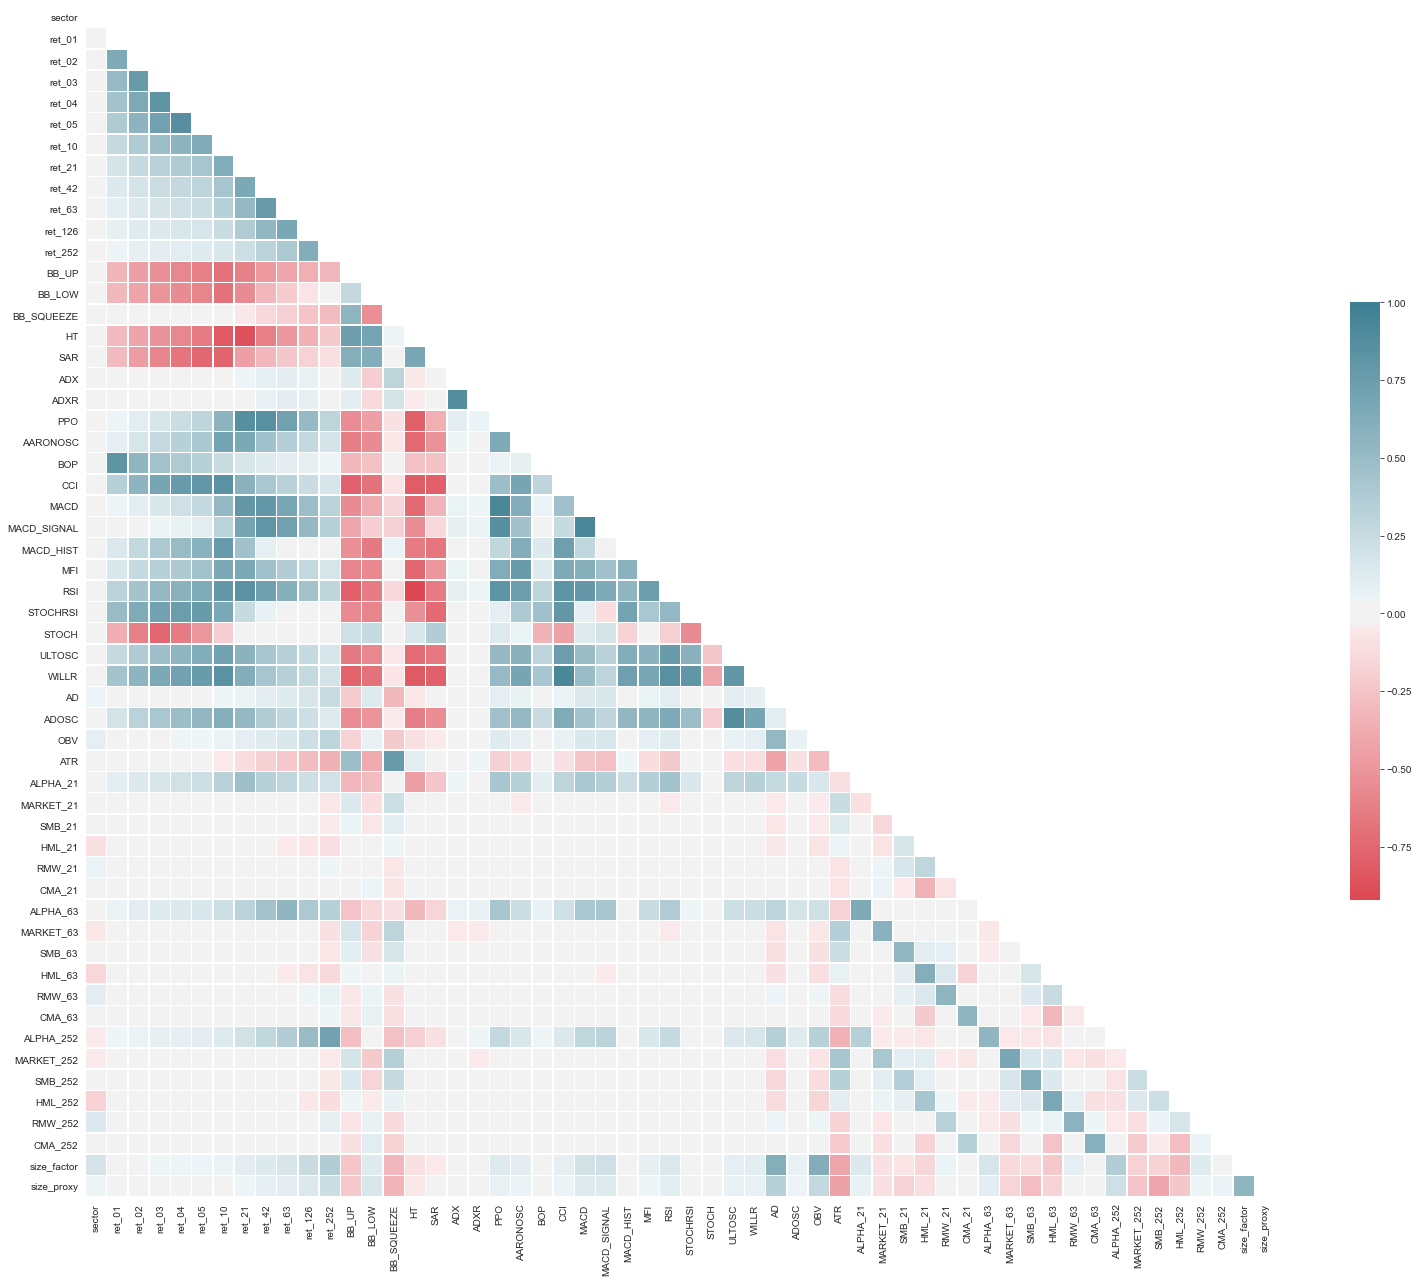

In [20]:
mask = np.triu(np.ones_like(corr_common, dtype=np.bool))
fig, ax = plt.subplots(figsize=(22, 18))
cmap = sns.diverging_palette(10, 220, as_cmap=True)

sns.heatmap(corr_common, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
fig.tight_layout()
fig.savefig('figures/factor_corr_common', dpi=300);

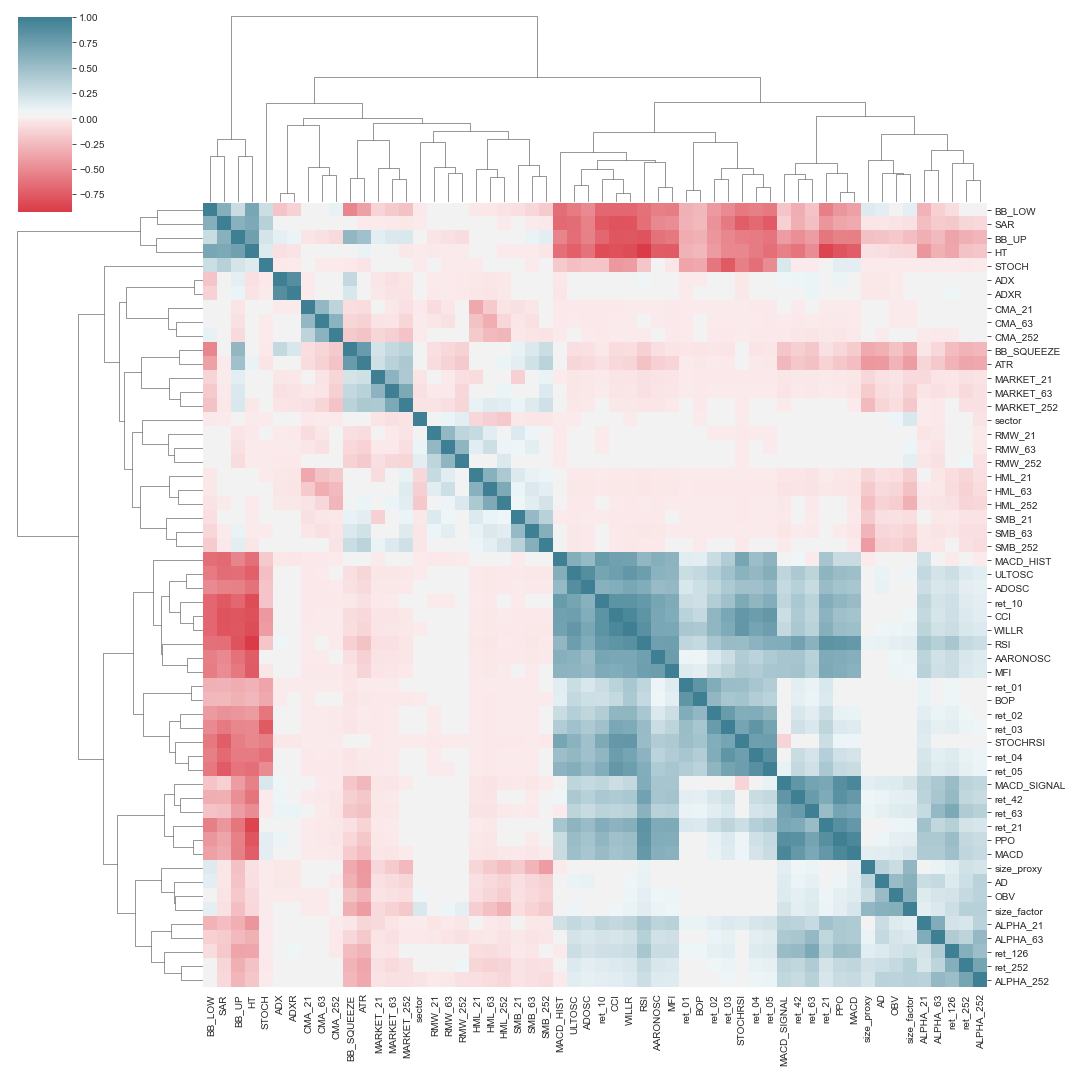

In [21]:
g = sns.clustermap(corr_common, cmap=cmap, figsize=(15, 15))
g.savefig('figures/factor_corr_common_cluster', dpi=300);

In [23]:
corr_ = corr_common.stack().reset_index()
corr_.columns = ['x1', 'x2', 'rho']
corr_ = corr_[corr_.x1!=corr_.x2].drop_duplicates('rho')

In [24]:
corr_.nlargest(5, columns='rho').append(corr_.nsmallest(5, columns='rho'))

,x1,x2,rho
1312,MACD,MACD_SIGNAL,0.936793
1263,CCI,WILLR,0.925544
1087,PPO,MACD,0.925282
970,ADX,ADXR,0.885147
1713,ULTOSC,ADOSC,0.881911
867,HT,RSI,-0.923566
407,ret_21,HT,-0.866342
351,ret_10,HT,-0.828103
871,HT,WILLR,-0.825403
862,HT,CCI,-0.806064


### Formulaic Alphas

In [25]:
%%time
corr_formula = factors[alphas].sort_index().corr(method='spearman').dropna(how='all', axis=1)
corr_formula.to_hdf('data.h5', 'correlation/formula')

CPU times: user 11min 38s, sys: 6.04 s, total: 11min 44s
Wall time: 11min 45s


In [26]:
corr_formula = corr_formula.dropna(how='all').dropna(how='all', axis=1)

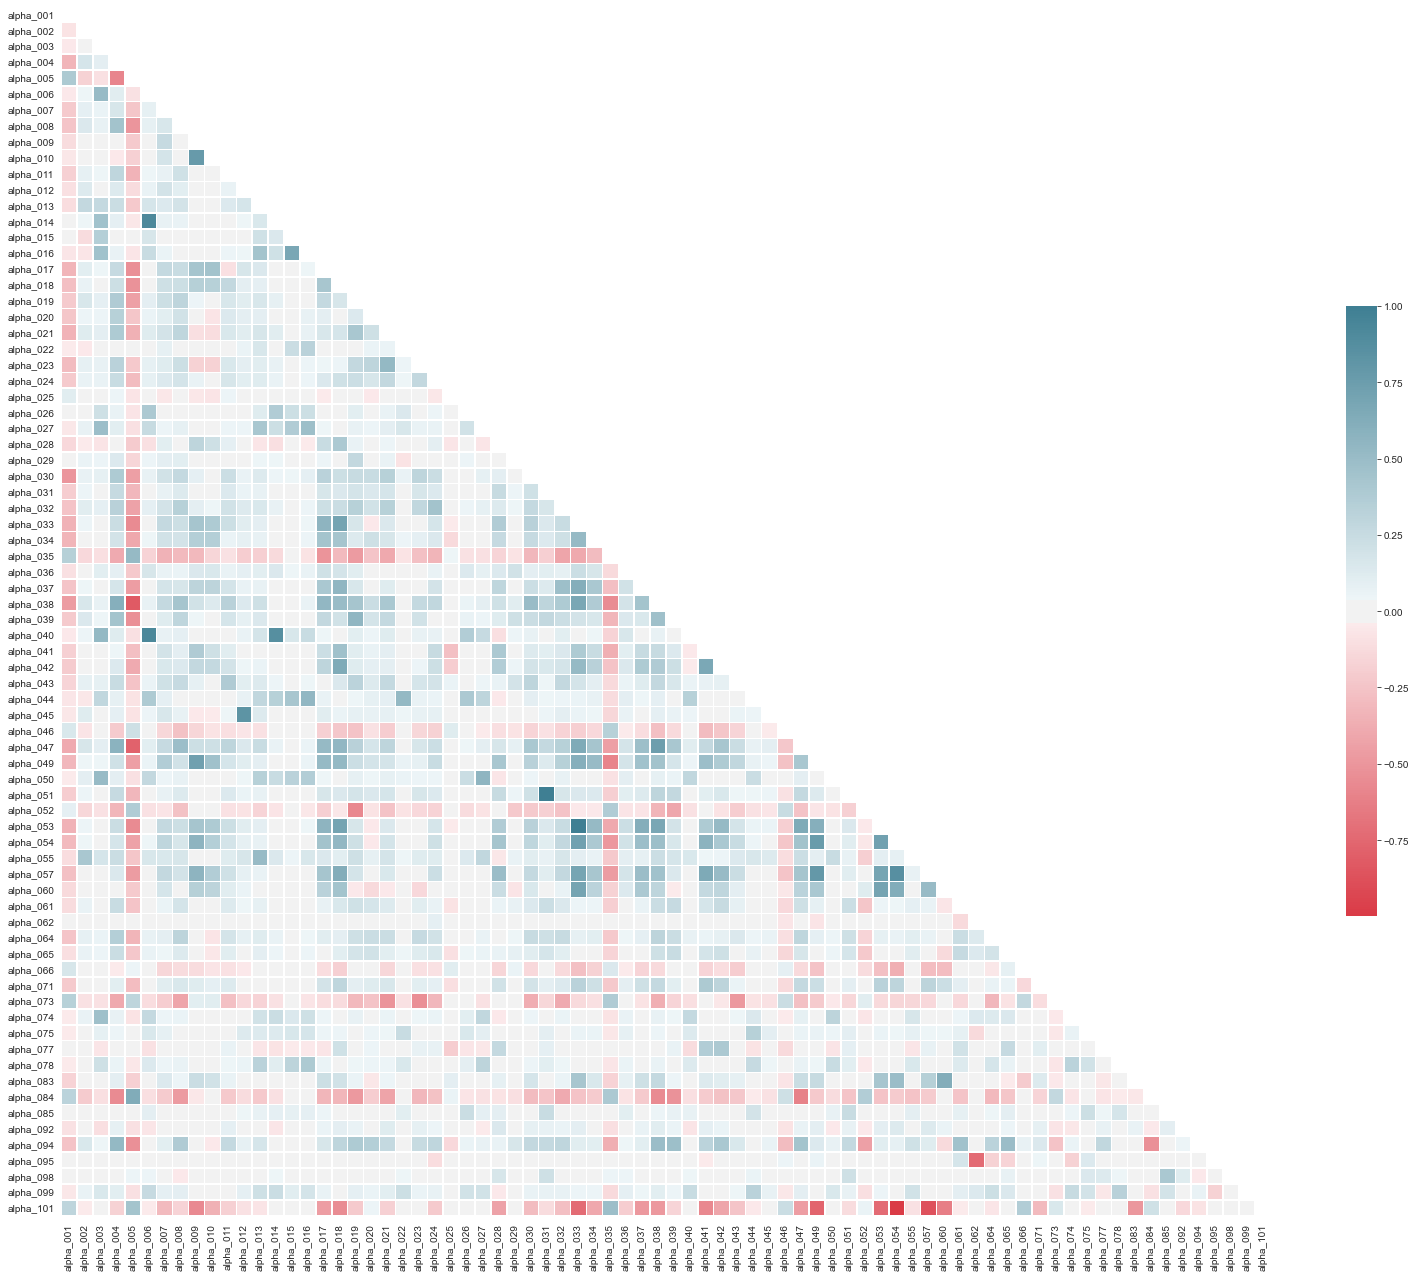

In [27]:
mask = np.triu(np.ones_like(corr_formula, dtype=np.bool))
fig, ax = plt.subplots(figsize=(22, 18))
cmap = sns.diverging_palette(10, 220, as_cmap=True)

sns.heatmap(corr_formula, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
fig.tight_layout()
fig.savefig('figures/factor_correlation_formula', dpi=300);

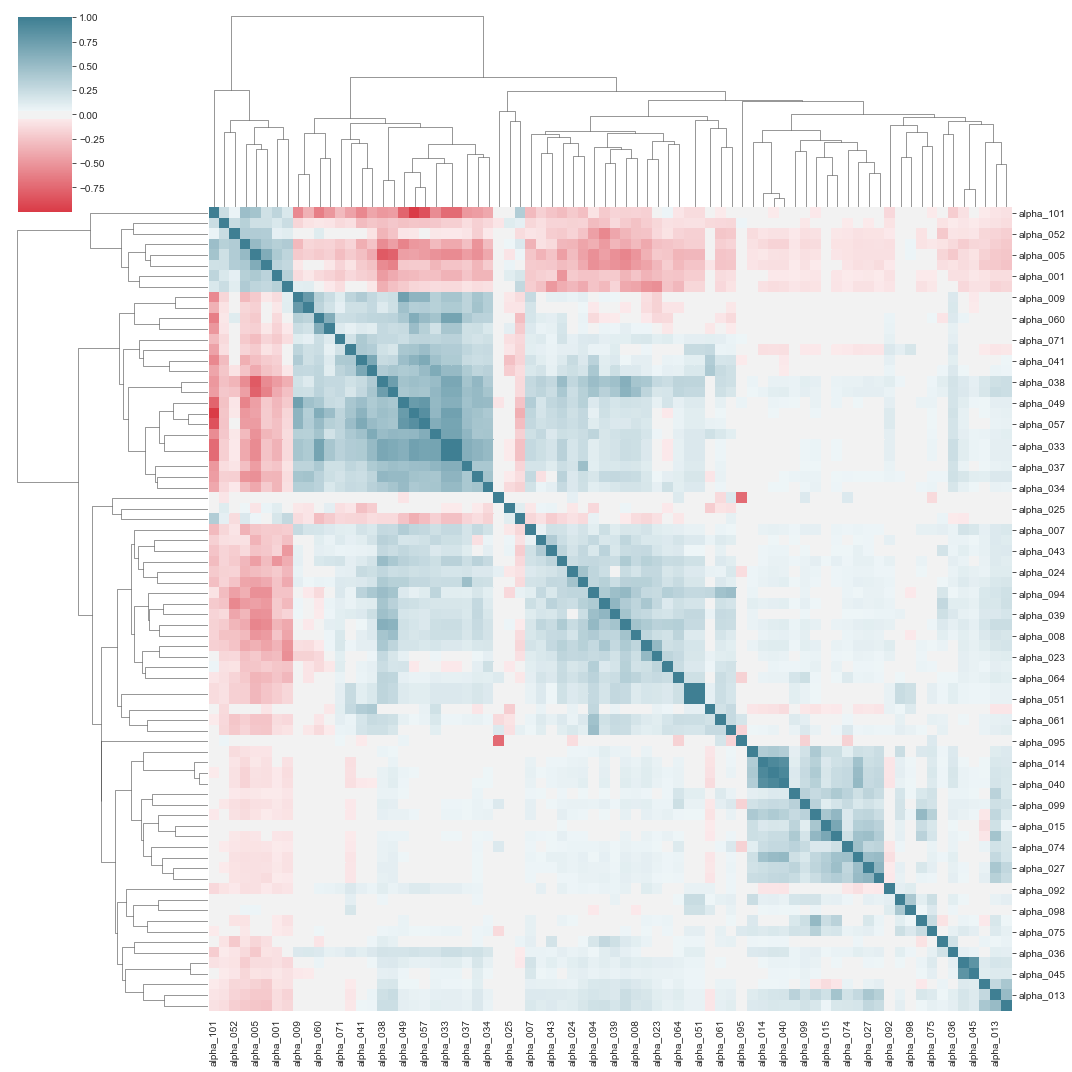

In [28]:
g = sns.clustermap(corr_formula.replace((np.inf, -np.inf), np.nan), cmap=cmap, figsize=(15, 15))
g.savefig('figures/factor_correlation_formula_cluster', dpi=300);

In [29]:
corr_formula_ = corr_formula.stack().reset_index()
corr_formula_.columns = ['x1', 'x2', 'rho']
corr_formula_ = corr_formula_[corr_formula_.x1!=corr_formula_.x2].drop_duplicates('rho')

In [30]:
corr_formula_.nlargest(5, columns='rho').append(corr_formula_.nsmallest(5, columns='rho'))

,x1,x2,rho
2329,alpha_031,alpha_051,1.000000
419,alpha_006,alpha_040,0.927969
393,alpha_006,alpha_014,0.919212
1027,alpha_014,alpha_040,0.870122
4006,alpha_054,alpha_057,0.867142
4027,alpha_054,alpha_101,-0.999155
4179,alpha_057,alpha_101,-0.872457
341,alpha_005,alpha_038,-0.821872
350,alpha_005,alpha_047,-0.779232
3647,alpha_049,alpha_101,-0.767716


### All Factors

In [31]:
corr = factors.drop(['ret_fwd', 'alpha_051'], axis=1).corr()

In [32]:
corr = corr.dropna(how='all').dropna(how='all', axis=1)

In [33]:
corr.to_hdf('data.h5', 'correlation/all')

In [34]:
corr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 131 entries, sector to alpha_101
Columns: 131 entries, sector to alpha_101
dtypes: float64(131)
memory usage: 135.1+ KB


In [35]:
corr.shape

(131, 131)

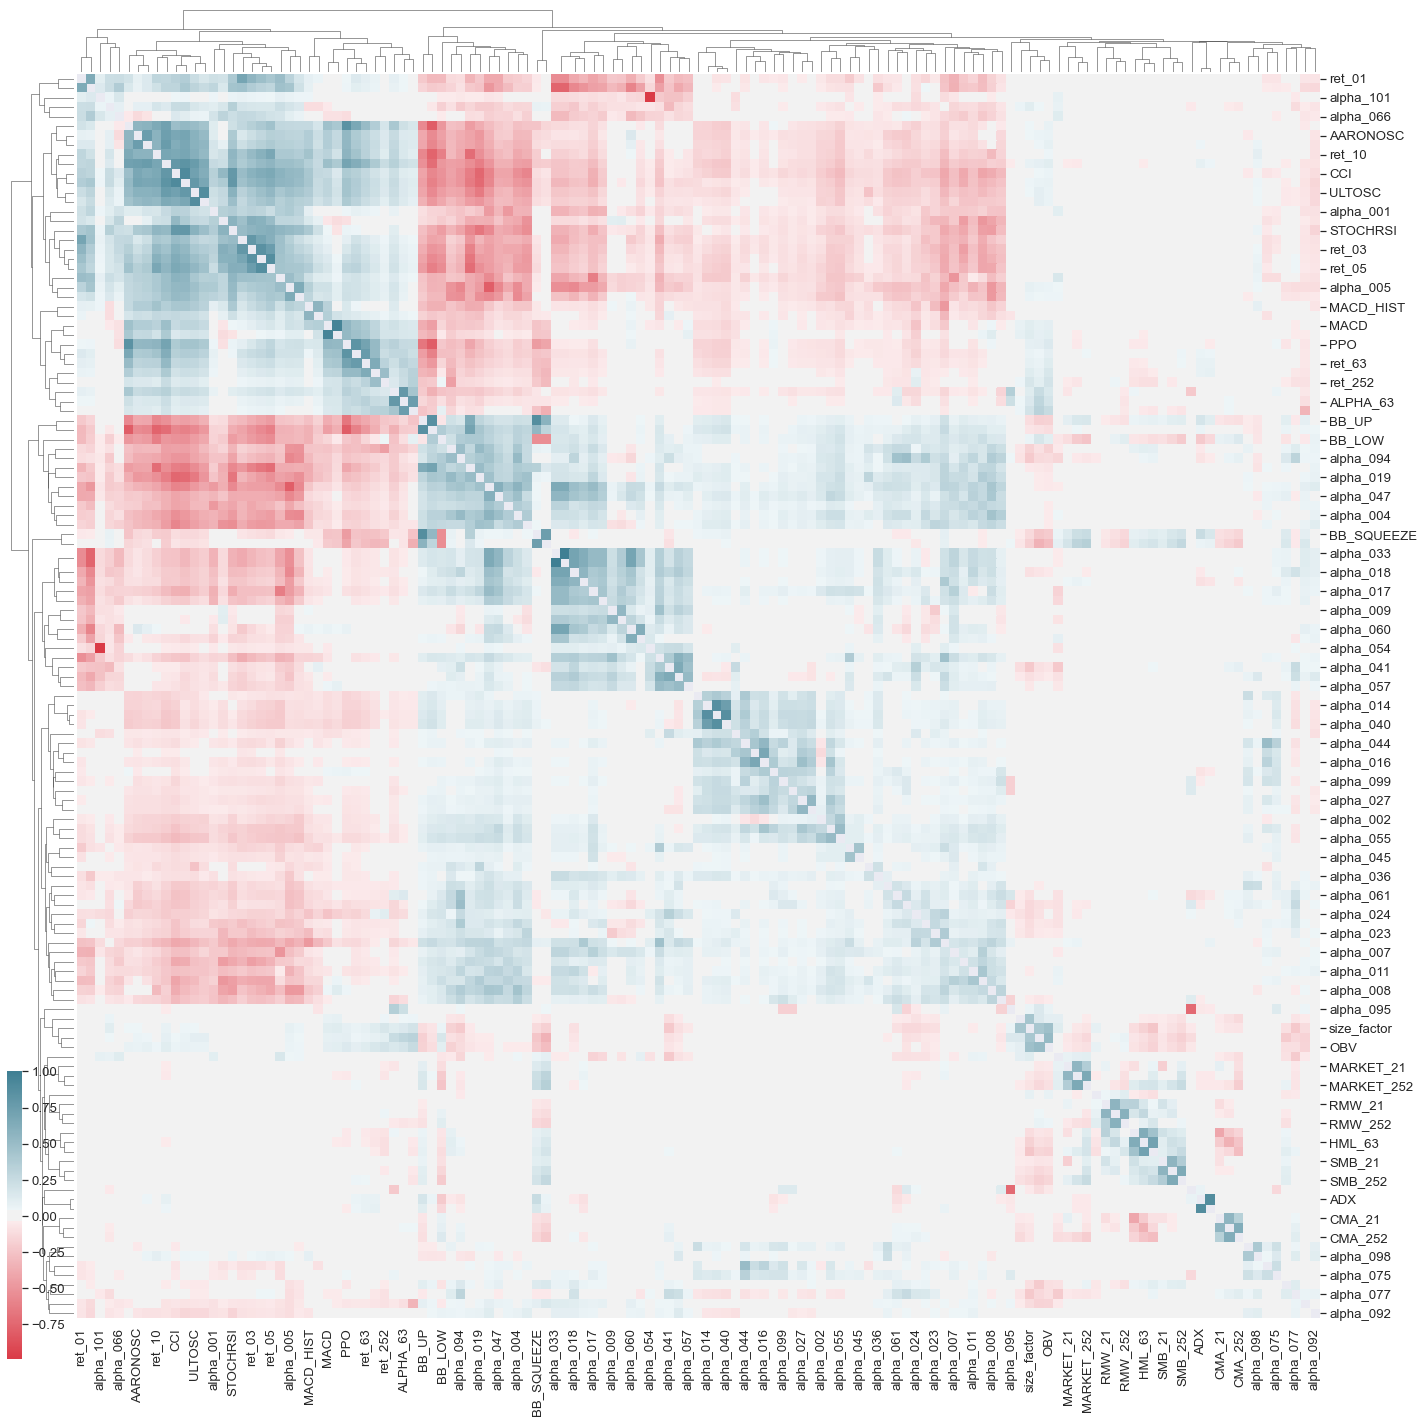

In [36]:
sns.set(font_scale=1.2)

mask = np.zeros_like(corr)
np.fill_diagonal(mask, 1)

g = sns.clustermap(corr, 
                   cmap=cmap, 
                   figsize=(20, 20), 
                   dendrogram_ratio=.05,
                   mask=mask,
                   cbar_pos=(0.01, 0.05, 0.01, 0.2));

g.savefig('figures/factor_correlation_all', dpi=300);

## Forward return correlation

In [37]:
fwd_corr = factors.drop(['ret_fwd', 'alpha_051'], axis=1).corrwith(factors.ret_fwd, method='spearman')

In [38]:
fwd_corr = fwd_corr.dropna()

In [39]:
fwd_corr.to_hdf('data.h5', 'correlation/fwd_ret')

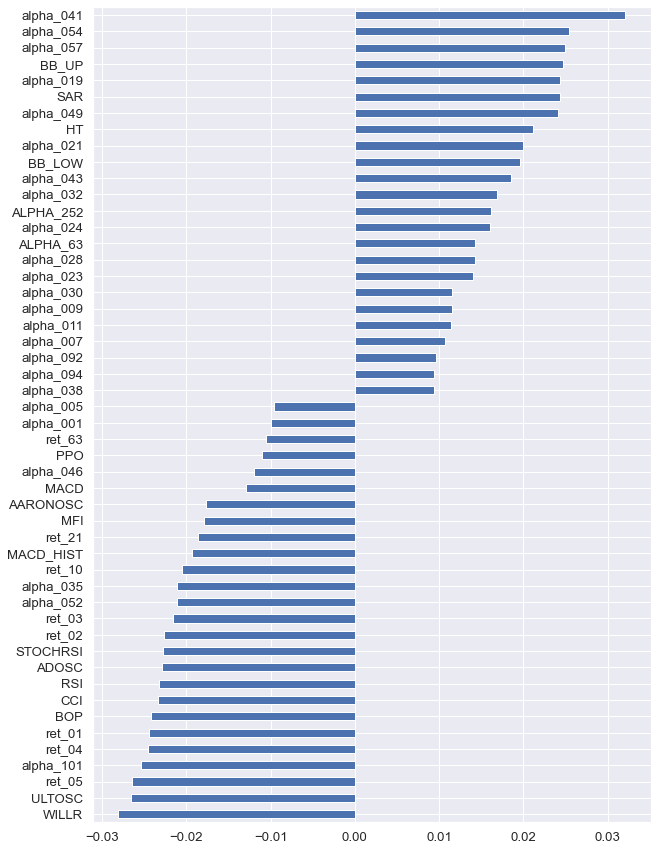

In [40]:
top50 = fwd_corr.abs().nlargest(50).index
fwd_corr.loc[top50].sort_values().plot.barh(figsize=(10, 15),
                                            legend=False);

## Mutual Information

In [ ]:
mi = pd.read_csv('mutual_info.csv', index_col=0, squeeze=True).to_dict()

In [ ]:
for feature in features:
    print(feature)
    df = (factors
          .loc[:, ['ret_fwd', feature]]
          .dropna().sample(n=100000))
    discrete_features = df[feature].nunique() < 10
    mi[feature] = mutual_info_regression(X=df[[feature]],
                                         y=df.ret_fwd,
                                         discrete_features=discrete_features)[0]
    pd.Series(mi).to_csv('mutual_info.csv')

In [ ]:
mi = pd.Series(mi)

In [ ]:
mi.to_hdf('data.h5', 'mutual_information')

## LightGBM Feature Importance

In [41]:
def get_fi(model):
    fi = model.feature_importance(importance_type='gain')
    return (pd.Series(fi / fi.sum(),
                      index=model.feature_name()))

In [42]:
def ic_lgbm(preds, train_data):
    """Custom IC eval metric for lightgbm"""
    is_higher_better = True
    return 'ic', spearmanr(preds, train_data.get_label())[0], is_higher_better

In [43]:
uniques = factors.nunique()

In [44]:
categoricals = uniques[uniques < 20].index.tolist()

In [45]:
categoricals

['sector',
 'alpha_004',
 'alpha_021',
 'alpha_027',
 'alpha_061',
 'alpha_062',
 'alpha_064',
 'alpha_065',
 'alpha_068',
 'alpha_073',
 'alpha_074',
 'alpha_075',
 'alpha_086',
 'alpha_092',
 'alpha_095',
 'alpha_099']

In [46]:
features = factors.columns.difference(fwd_returns).tolist()

In [47]:
label = 'ret_fwd'

In [59]:
train_length = int(8.5 * 252)
test_length = 252
n_splits = 1

In [60]:
params = dict(boosting='gbdt',
              objective='regression',
              verbose=-1,
              metric='None')
num_boost_round = 5000

In [61]:
lgb_data = lgb.Dataset(data=factors.loc[:, features],
                       label=factors.loc[:, label],
                       categorical_feature=categoricals,
                       free_raw_data=False)

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          lookahead=1,
                          test_period_length=test_length,
                          train_period_length=train_length)

feature_importance, ic, daily_ic = [], [], []

for i, (train_idx, test_idx) in enumerate(cv.split(X=factors)):
    start = time()
    lgb_train = lgb_data.subset(train_idx.tolist()).construct()
    lgb_test = lgb_data.subset(test_idx.tolist()).construct()
    evals_result = {}
    model = lgb.train(params=params,
                      train_set=lgb_train,
                      num_boost_round=num_boost_round,
                      valid_sets=[lgb_train, lgb_test],
                      valid_names=['train', 'valid'],
                      feval=ic_lgbm,
                      evals_result=evals_result,
                      early_stopping_rounds=500,
                      verbose_eval=100)
    model.save_model(f'models/lgb_model.txt')
    fi = get_fi(model)
    fi.to_hdf('data.h5', f'fi/{i:02}')
    test_set = factors.iloc[test_idx, :]
    X_test = test_set.loc[:, model.feature_name()]
    y_test = test_set.loc[:, label]
    y_pred = model.predict(X_test)
    cv_preds = y_test.to_frame('y_test').assign(y_pred=y_pred)
    cv_preds.to_hdf('preds.h5', f'preds/{i:02}')

    by_day = cv_preds.groupby(level='date')
    ic_by_day = by_day.apply(lambda x: spearmanr(x.y_test, x.y_pred)[0])
    daily_ic_mean = ic_by_day.mean()
    daily_ic_median = ic_by_day.median()
    ic = spearmanr(cv_preds.y_test, cv_preds.y_pred)[0]
    print(f'\n{time()-start:6.1f} | {ic:6.2%} | {daily_ic_mean: 6.2%} | {daily_ic_median: 6.2%}')

Training until validation scores don't improve for 500 rounds
[100]	train's ic: 0.150342	valid's ic: 0.0339492
[200]	train's ic: 0.2024	valid's ic: 0.0255251
[300]	train's ic: 0.233626	valid's ic: 0.0237942
[400]	train's ic: 0.2621	valid's ic: 0.0173379
[500]	train's ic: 0.283638	valid's ic: 0.0162211
[600]	train's ic: 0.303043	valid's ic: 0.0134461
Early stopping, best iteration is:
[104]	train's ic: 0.151908	valid's ic: 0.0339996

 239.5 |  3.40% |  2.01% |  1.63%


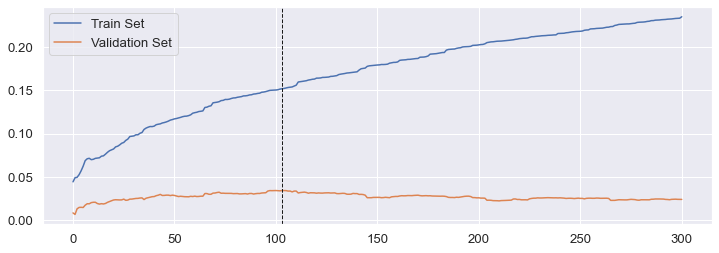

In [51]:
cv_result = pd.DataFrame({'Train Set': evals_result['train']['ic'], 
                          'Validation Set': evals_result['valid']['ic']})

ax = cv_result.loc[:300].plot(figsize=(12, 4))
ax.axvline(cv_result['Validation Set'].idxmax(), c='k', ls='--', lw=1);

## SHAP Values

In [52]:
shap.initjs()

In [53]:
# model = lgb.Booster(model_file='models/lgb_model.txt')

In [54]:
explainer = shap.TreeExplainer(model)

In [62]:
# workaround for SHAP version 0.30: https://github.com/slundberg/shap/issues/794
model.params['objective'] = 'regression'

In [ ]:
shap_values = explainer.shap_values(factors.iloc[train_idx, :].loc[:, model.feature_name()])

In [ ]:
np.save('models/shap_values.npy', shap_values)

In [64]:
shap_values = np.load('models/shap_values.npy')

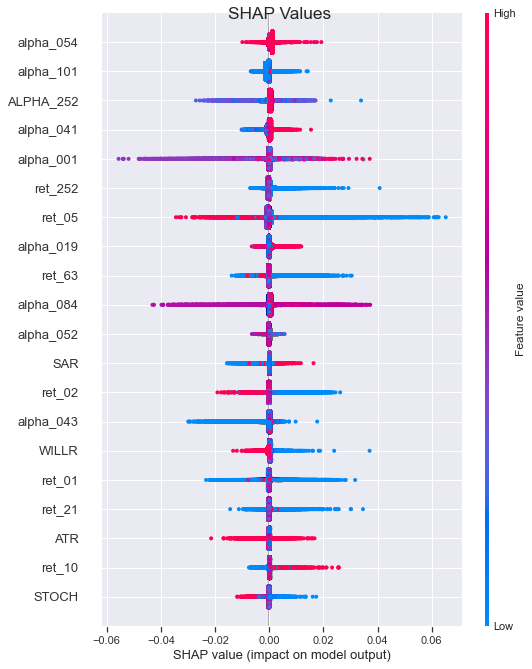

In [65]:
shap.summary_plot(shap_values,
                  factors
                  .iloc[train_idx, :]
                  .loc[:, model.feature_name()],
                  show=False)
plt.gcf().suptitle('SHAP Values')
plt.gcf().tight_layout()
plt.gcf().savefig('figures/shap_summary_dot', dpi=300)

In [66]:
shap_values = pd.DataFrame(shap_values, columns = features)

## Summary

In [67]:
mi = pd.read_hdf('data.h5', 'mutual_information')
fwd_corr = pd.read_hdf('data.h5', 'correlation/fwd_ret')

In [68]:
shap_summary = shap_values.abs().mean()
shap_summary /= shap_summary.sum()

In [69]:
stats = (mi.to_frame('Mutual Information')
         .join(fwd_corr.to_frame('Information Coefficient'))
         .join(fi.to_frame('Feature Importance'))
         .join(shap_summary.to_frame('SHAP Values')))

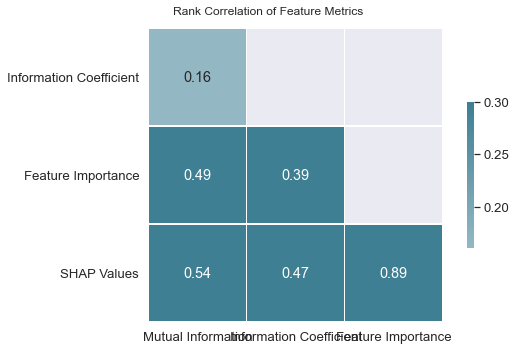

In [70]:
cols = {'Information Coefficient': stats['Information Coefficient'].abs()}
corr = stats.assign(**cols).corr('spearman')
mask = np.triu(np.ones_like(corr, dtype=np.bool))
corr = corr.iloc[1:, :-1]
mask = mask[1:, :-1]

fig, ax = plt.subplots(figsize=(8, 5))

cmap = sns.diverging_palette(10, 220, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f')
plt.xticks(rotation=0)
fig.suptitle('Rank Correlation of Feature Metrics', fontsize=12)
fig.tight_layout()
fig.subplots_adjust(top=.92)
fig.savefig('figures/metrics_correlation', dpi=300);

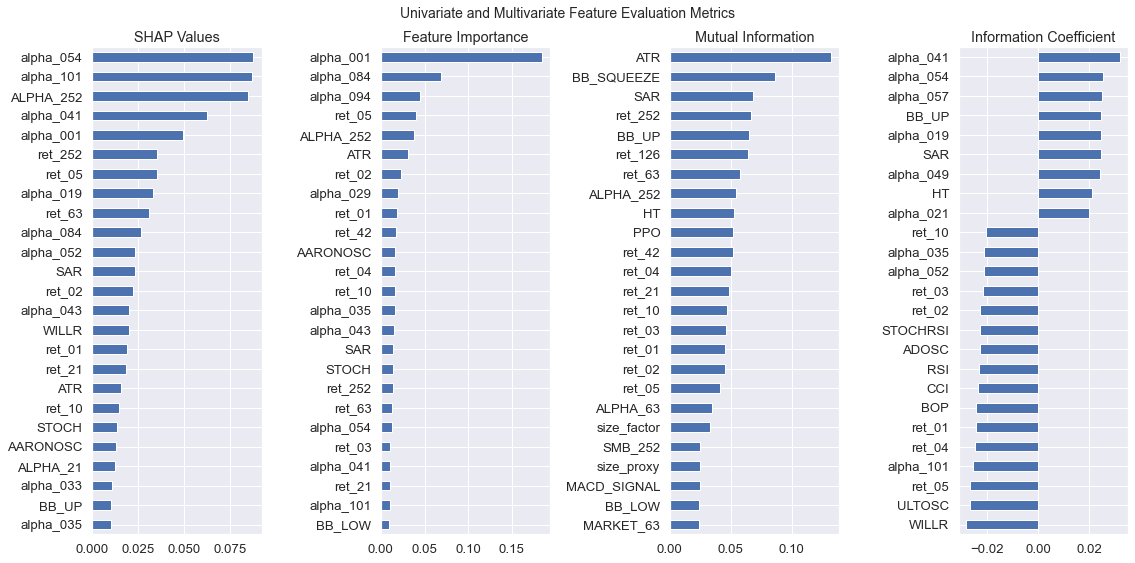

In [71]:
top_n = 25
fig, axes = plt.subplots(ncols=4, figsize=(16, 8))

shap_summary.nlargest(top_n).sort_values().plot.barh(ax=axes[0], title='SHAP Values')

fi.nlargest(top_n).sort_values().plot.barh(ax=axes[1], title='Feature Importance')

mi.nlargest(top_n).sort_values().plot.barh(ax=axes[2], title='Mutual Information')

top_corr = fwd_corr.abs().nlargest(top_n).index
fwd_corr.loc[top_corr].sort_values().plot.barh(ax=axes[3], title='Information Coefficient')

fig.suptitle('Univariate and Multivariate Feature Evaluation Metrics', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.91)
fig.savefig('figures/all_feature_metrics');